## Recurrent Neural Networks

Recurrent neural networks (RNNs) maintain a hidden state over time, which is a function of the current input and previous hidden state:

<center>

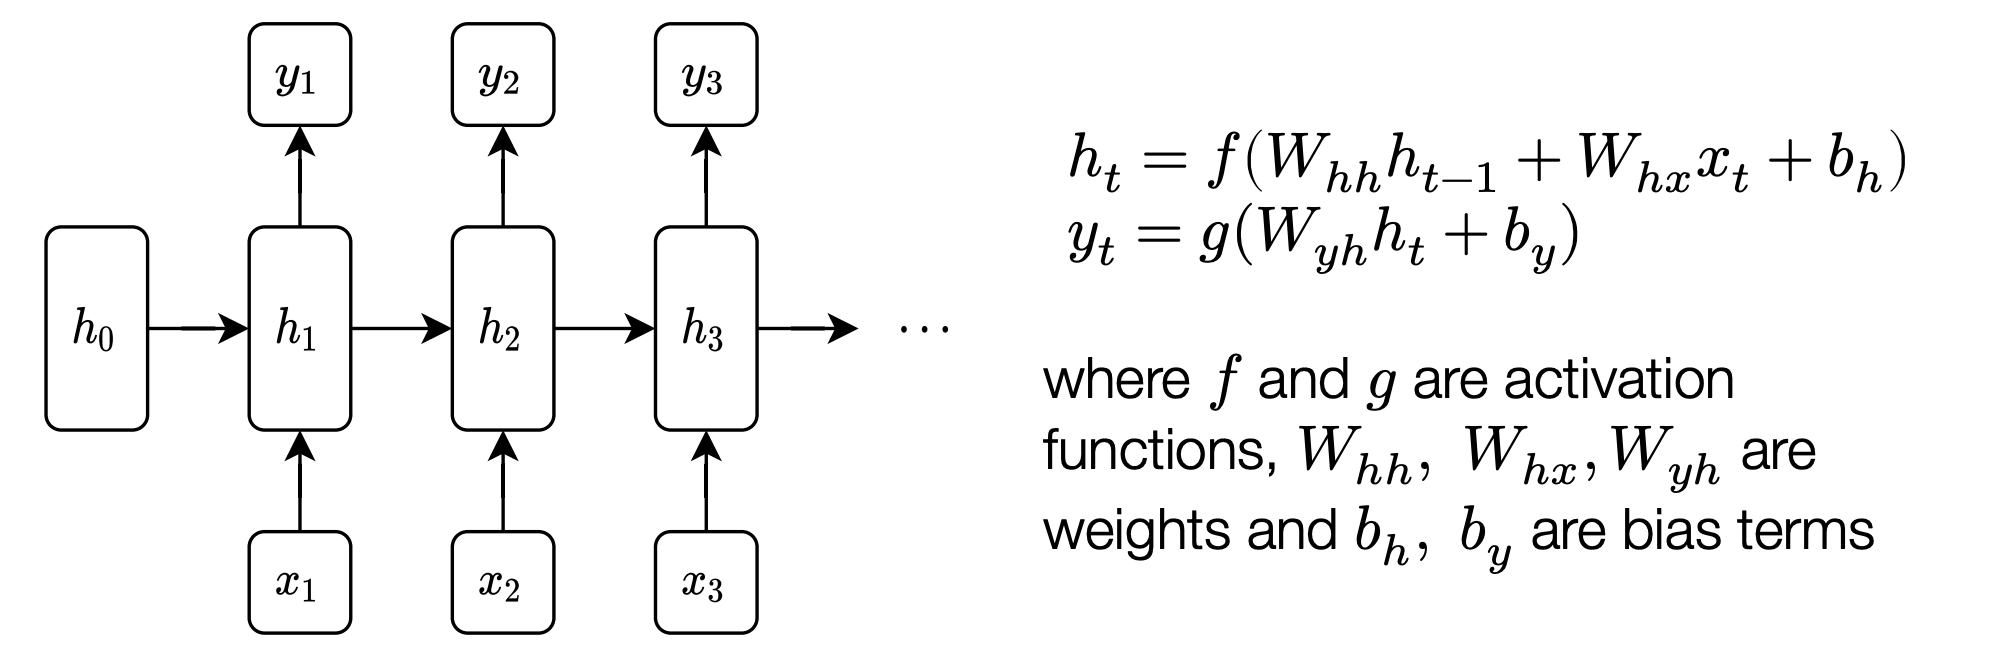

</center>

Where

* $h_t \in \mathbb{R}^d$ is a d-dimensional vector
* $x_t \in \mathbb{R}^n$ is a n-dimensional vector
* $y_t \in \mathbb{R}^k$ is a k-dimensional vector

This implies that

* $W_{hh} \in \mathbb{R}^{d \times d}$ is a $d\times d$ matrix
* $W_{hx} \in \mathbb{R}^{d \times n}$ is a $d\times n$ matrix
* $W_{yh} \in \mathbb{R}^{k \times d}$ is a $k\times d$ matrix
* $b_{h} \in \mathbb{R}^d$ is a d-dimensional vector
* $b_{y} \in \mathbb{R}^k$ is a k-dimensional vector

Each hidden state $h_{t}$ is some function of the past hidden state $h_{t-1}$ and the input $x_{t}$. 

In addition, there is no equation for $h_{0}$.

### Training RNN

Given a sequence of inputs and target outputs $\left(x_1, \ldots, x_T, y_1^{\star}, \ldots, y_T^{\star}\right)$, we can train an RNN using back-propagation through time, which just involves "unrolling" the RNN over the length of the sequence, then relying mostly on autodiff:

```python
# Optimizer
opt = Optimizer(params = (W_hh, W_hx, W_yh, b_h, b_y))
# Initialize first hidden state to zero
h[0] = 0
# Initialize loss to zero
l = 0

for t = 1,...,T:
    # Current hidden state, which is a function of the previous hidden state and the input
    h[t] = f(W_hh * h[t-1] + W_hx * x[t] + b_h)
    # Output prediction, which is function of the current hidden state
    y[t] = g(W_yh * h[t] + b_y)
    # Compute loss between the prediction and the true target
    l += Loss(y[t], y_star[t])
# Auto-differentiation
l.backward()
# Update parameters
opt.step()
```

This whole procedure is referred to as back-propagation through time (BPTT).

### Stacking RNNs

Just like normal neural networks, RNNs can be stacked together, treating the hidden units of one layer as the inputs to the next layer's hidden units, to form “deep” RNNs. Practically speaking, there tends to be less value in “very deep” RNNs than for other architectures.

<center>

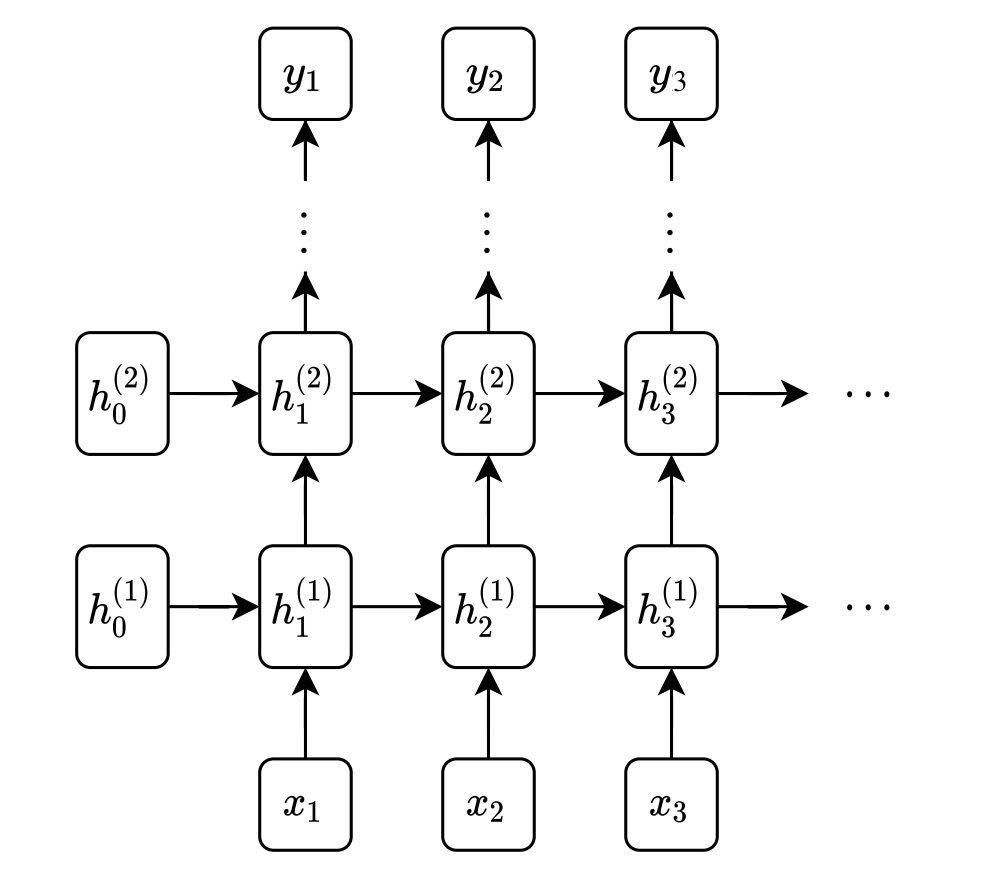

</center>

When we stack RNNs, the outputs from the previous layer $y_{t}^{(i)}$ become the inputs to the next layers' hidden units $h_{t}^{i+1}$. 

The sequence $y_{t}$ outputted by stacks of layers still obeys the temporal dependency as in the single layer RNN case. In the computational graph, $y_{2}$ is only a function of $x_{1}$ and $x_{2}$. Similarly, $y_{3}$ is only a function of $x_{1}$, $x_{2}$, and $x_{3}$, even when we stack the layers to create a deeper model.

### Exploding Activations & Gradients

The challenge for training RNNs is similar to that of training deep MLP networks. Because we train RNNs on long sequences, if the weights/activation of the RNN are scaled poorly, the hidden activations (and therefore also the gradients) will grow unboundedly with sequence length.

<center>

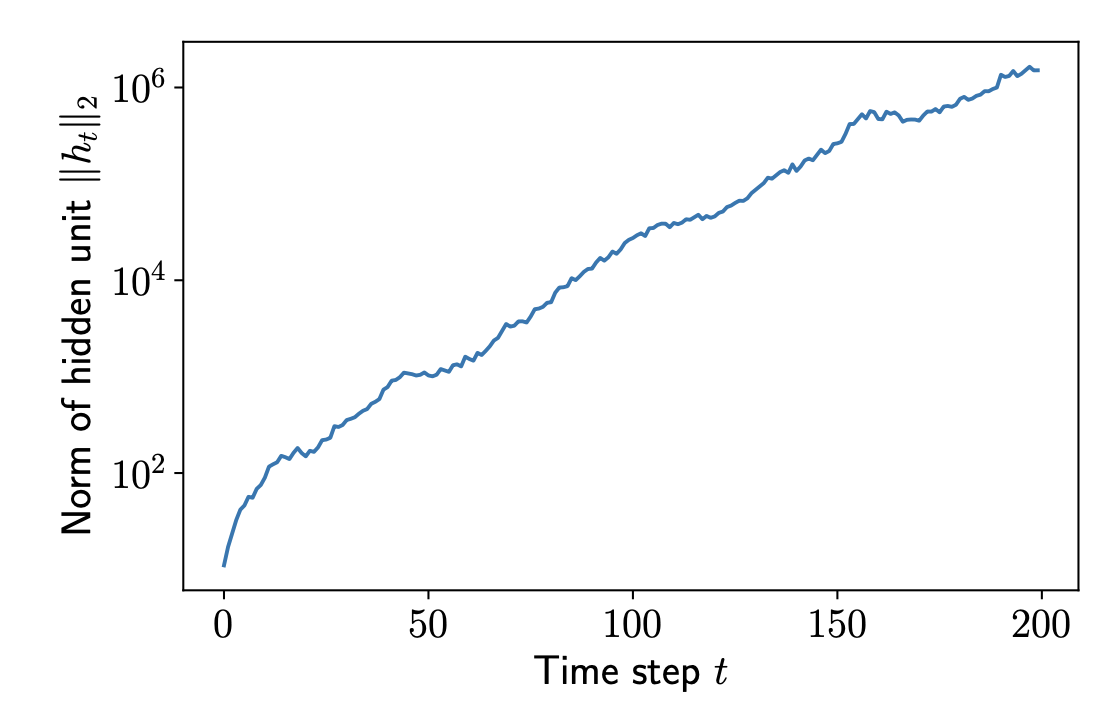

</center>

The plot above uses a single layer RNN with ReLU activations, using weight initialization
$$
W_{h h} \sim \mathcal{N}(0,3 / n)
$$
Recall that $\sigma^2=2 / n$ was the "proper" initialization for ReLU activations. As can be seen, activation norms explode over time.

### Vanishing Activations & Gradients

Similarly, if weights are too small then information from the inputs will quickly decay with time (and it is precisely the “long range” dependencies that we would often like to model with sequence models).

<center>

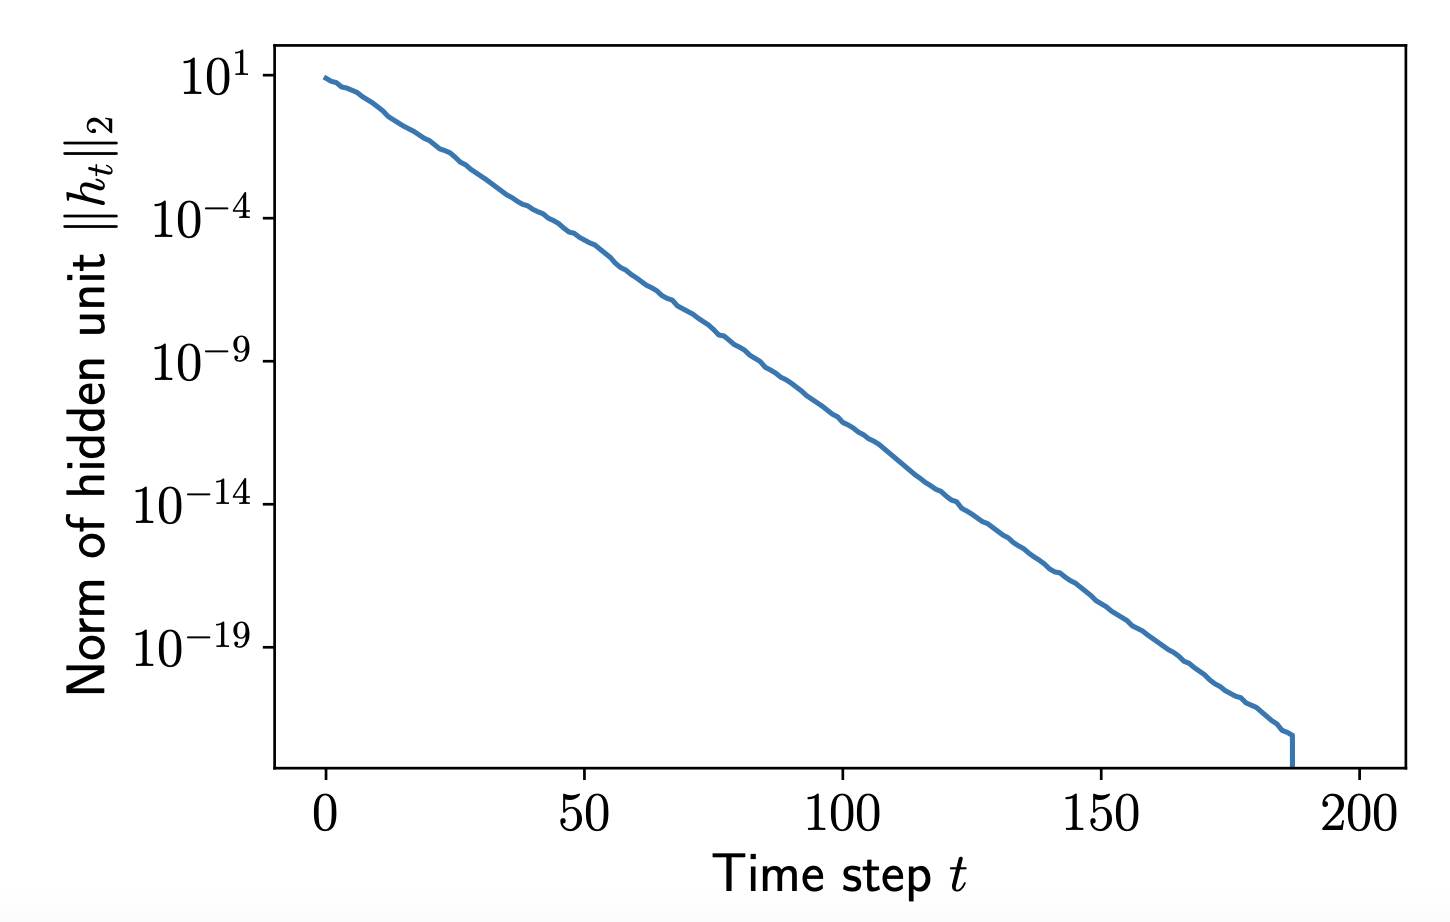

</center>

This plot uses a single layer RNN with ReLU activations, using weight initialization
$$
W_{h h} \sim \mathcal{N}(0,1.5 / n)
$$
Non-zero input only provided here for time 1, showing decay of information about this input over time.

### Alternative Activations

One obvious problem with ReLU is that it can grow unboundedly; does using bounded activations "fix" this problem?

<center>

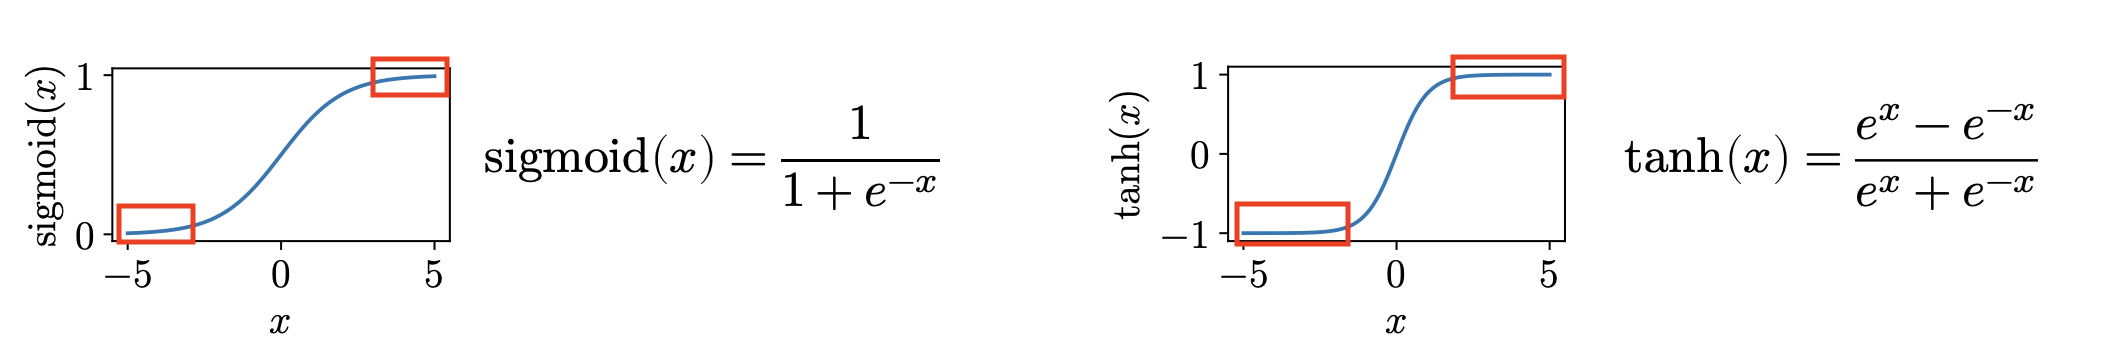

</center>

The answer is no, since creating large enough weights (solving trivially the exploding gradients $\&$ activations) to not cause activations/gradients to vanish requires being in the "saturating" (red boxes) regions of the activations, where gradients are very small. Therefore, we still have vanishing gradients problem.

## LSTM

Long short term memory (LSTM) cells are a particular form of hidden unit update that avoids (some of) the problems of vanilla RNNs:

### Step 1

Divide the hidden unit into two components, called (confusingly) the **hidden state** and the **cell state**. Importantly, the cell state is simply another component of the hidden state, which has a different update rule. Put it another way, at time $t$, both the hidden state and the cell state are both elements of the hidden for the LSTM layer.

<center>

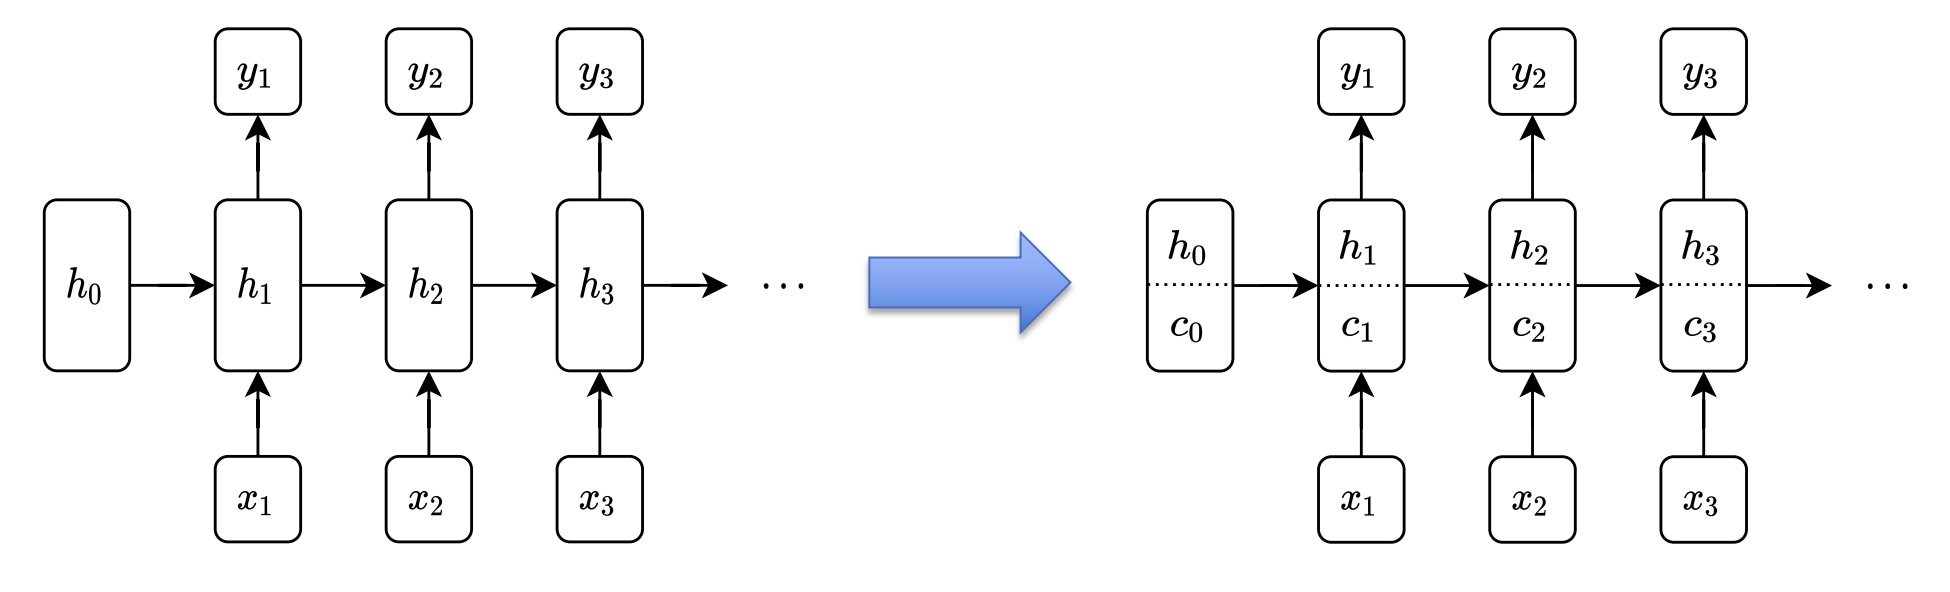

</center>

### Step 2

Use a very specific formula to update the hidden state and cell state (throwing in some other names, like “forget gate”, “input gate”, “output gate” for good measure):

$$
\left[\begin{array}{c}
i_t \\
f_t \\
g_t \\
o_t
\end{array}\right]=\left(\begin{array}{c}
\text { sigmoid } \\
\text { sigmoid } \\
\text { tanh } \\
\text { sigmoid }
\end{array}\right)\underbrace{\left(\underbrace{W_{h h}}_{4d \times d} \underbrace{h_{t-1}}_{d \times 1}+\underbrace{\mathrm{W}_{h x}}_{4d \times n} \underbrace{x_t}_{n \times 1}+\underbrace{b_h}_{4d \times 1}\right)}_{h_{t} \in \mathbb{R}^{4d}}
$$

Note that $i_{t}$ (input gate), $f_t$ (forget gate), $g_t$ (cell gate or input note), $o_t$ (output gate) are all vectors $\mathbb{R}^d$. They are intermediate terms formed by applying different activation functions to $h_{t}$ (after splitting it into four d-dimensional vectors), which we can then use to form the current hidden and cell states. As can be seen from the formulas, they are functions of the previous hidden state as well as the input $x_{t}$.

Then, the hidden and cell states for the current time $t$ are formed by:

$$
\begin{aligned}
& c_t=c_{t-1} \circ f_t+i_t \circ g_t \\
& h_t=\tanh \left(c_t\right) \circ o_t
\end{aligned}
$$

where $\circ$ means (Hadamard) element-wise product. Note that $c_t$ and $h_t$ are also vector $\mathbb{R}^d$.

<center>

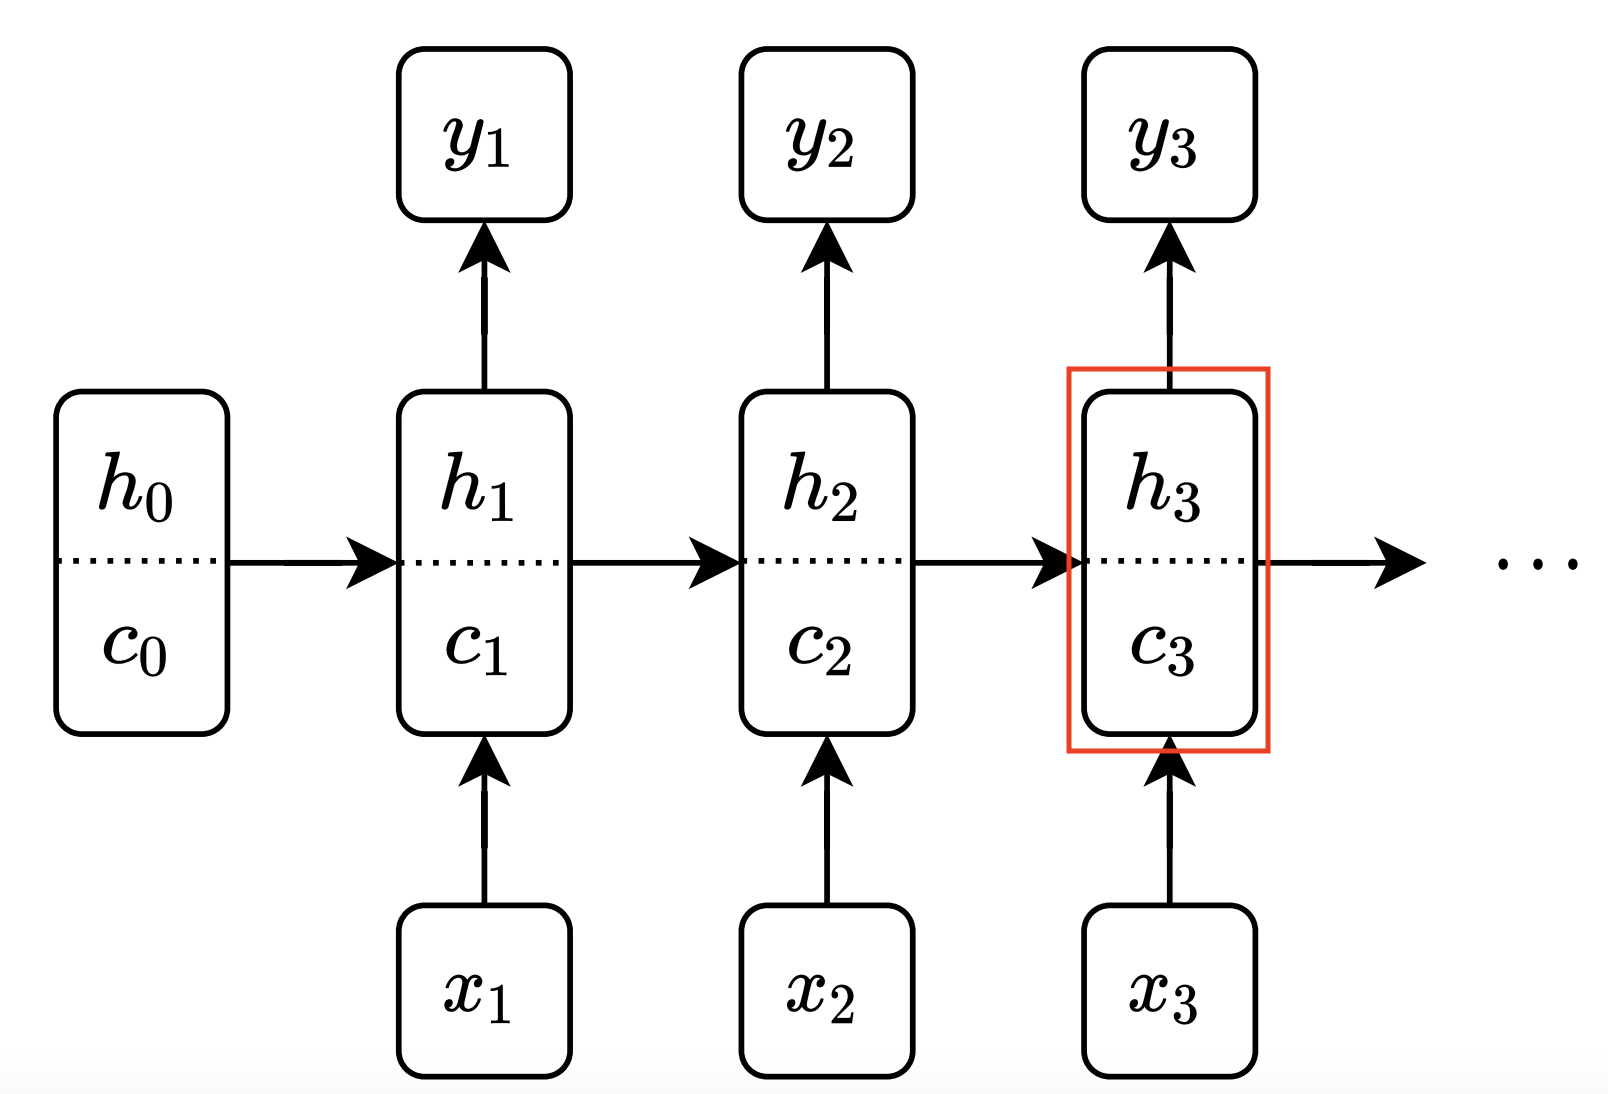

</center>

This means that the total hidden state size (red box) is $\mathbb{R}^{2d}$ since $h_{t}$ and $c_{t}$ are both $\mathbb{R}^d$.

### Why do LSTMs Work?

The term “long short-term memory” comes from the following intuition. Simple recurrent neural networks have long-term memory in the form of weights. The weights change slowly during training, encoding general knowledge about the data. They also have short-term memory in the form of ephemeral activations, which pass from each node to successive nodes. The LSTM model introduces an intermediate type of storage via the memory cell. A memory cell is a composite unit, built from simpler nodes in a specific connectivity pattern, with the novel inclusion of multiplicative nodes.

The key distinction between vanilla RNNs and LSTMs is that the latter support gating of the hidden state. This means that we have dedicated mechanisms for when a hidden state should be updated and also when it should be reset. These mechanisms are learned and they address the concerns listed above. For instance, if the first token is of great importance we will learn not to update the hidden state after the first observation. Likewise, we will learn to skip irrelevant temporary observations. Last, we will learn to reset the latent state whenever needed.

<center>

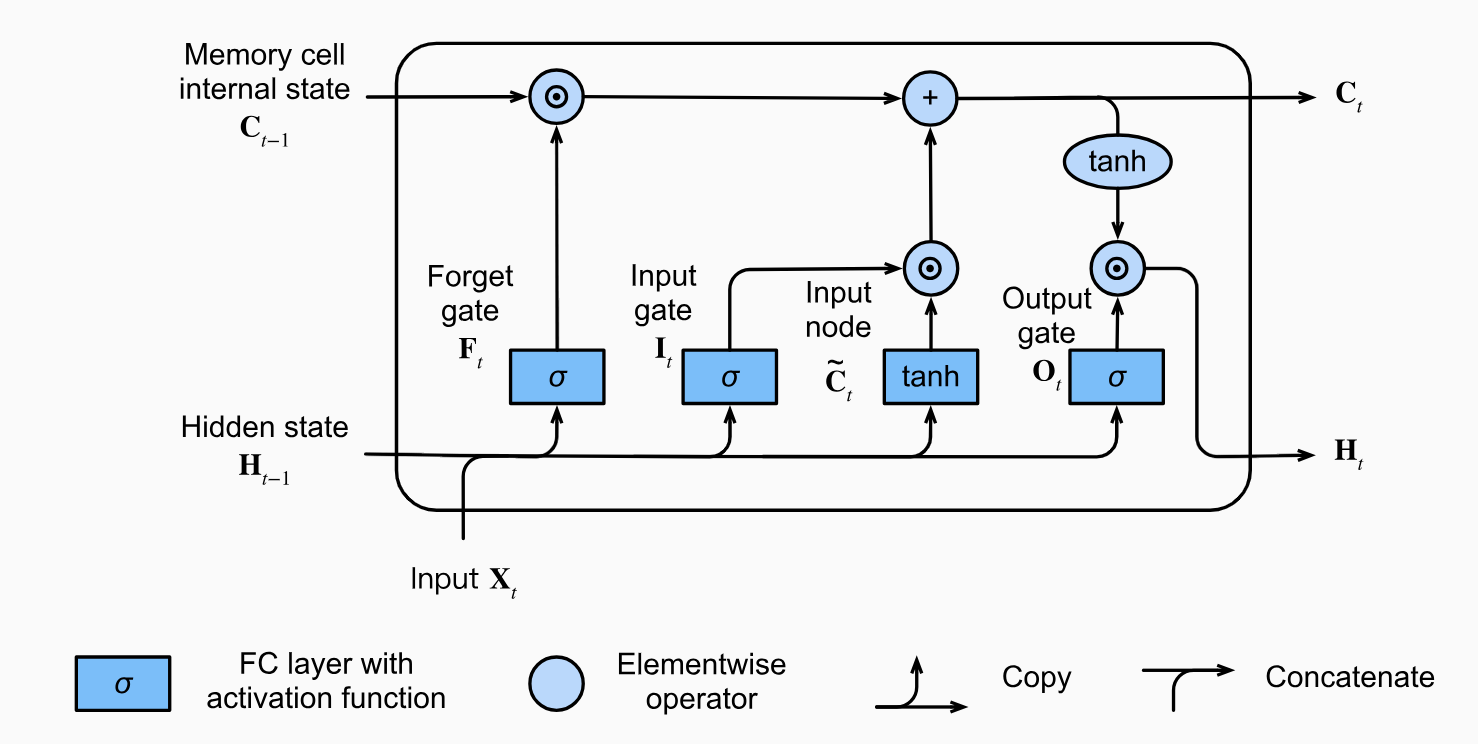

</center>


Intuitively, for cell states:

  - In LSTMs, the input gate $\mathbf{i}_t$ governs how much we take new data into account via $c_t$ and the forget gate $f_t$ addresses how much of the old cell internal state $c_{t-1}$ we retain. 
  - If the forget gate is always 1 and the input gate is always 0, the *previous* cell state $c_{t-1}$ will remain constant forever, passing unchanged to each subsequent time step. However, input gates and forget gates give the model the flexibility to learn when to keep this value unchanged and when to perturb it in response to subsequent inputs. In practice, this design alleviates the vanishing gradient problem, resulting in models that are much easier to train, especially when facing datasets with long sequence lengths.
  
For hidden states:

  - We first apply to the current cell state $c_{t}$ and then apply another point-wise multiplication with the output gate (also sigmoid). This ensures that the values of $h_{t}$ are always in the interval $[1, -1]$.
  - Whenever the output gate is close to 1, we allow the *current* cell state to impact the subsequent layers uninhibited, whereas for output gate values close to 0, we prevent the current memory from impacting other layers of the network at the current time step.
  - Note that a memory cell can accrue information across many time steps without impacting the rest of the network (so long as the output gate takes values close to 0), and then suddenly impact the network at a subsequent time step as soon as the output gate flips from values close to 0 to values close to 1.